# Imports

In [2]:
import gc
import json
import xgboost
import geopandas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm.notebook import tqdm
from time import time
from matplotlib import pyplot
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from pompier_utils import convert_dates, parse_osrm, add_distance, add_distance_vol 
from pompier_utils import parse_GPS_tracks, make_vehicle_categories

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

%matplotlib inline

# Read data

In [4]:
BASE_PATH = "./input/pompiers/"

X_train = pd.read_csv(BASE_PATH + 'x_train.csv')
X_test  = pd.read_csv(BASE_PATH + 'x_test.csv')
y_train = pd.read_csv(BASE_PATH + 'y_train.csv')

X_train_add = pd.read_csv(BASE_PATH + 'x_train_additional_file.csv')
X_test_add  = pd.read_csv(BASE_PATH + 'x_test_additional_file.csv')


X_train = X_train.merge(y_train,     on='emergency vehicle selection')
X_train = X_train.merge(X_train_add, on='emergency vehicle selection')
X_test  = X_test .merge(X_test_add,  on='emergency vehicle selection')


X_train = X_train.drop('status preceding selection', axis=1)
X_test  = X_test .drop('status preceding selection', axis=1)

print(f'Train shape {X_train.shape} \nTest shape  {X_test.shape}')

Train shape (219337, 33) 
Test shape  (108033, 30)


# Preprocessing

In [5]:
print('– Convert dates')
X_train = convert_dates(X_train)
X_test = convert_dates(X_test)

print('– Add distance between departure and intervention')
X_train = add_distance(X_train)
X_test = add_distance(X_test)

print('– Parse OSRM responses')
X_train = parse_osrm(X_train)
X_test = parse_osrm(X_test)

print('– Add distance between OSRM points')
X_train = add_distance_vol(X_train)
X_test = add_distance_vol(X_test)

print('– Parse GPS tracks')
X_train = parse_GPS_tracks(X_train)
X_test = parse_GPS_tracks(X_test)

print('– Add vehicle category')
X_train, X_test = make_vehicle_categories(X_train, X_test)

– Convert dates
– Add distance between departure and intervention


– Parse OSRM responses
– Add distance between OSRM points


– Parse GPS tracks
– Add vehicle category


In [6]:
X_train.head(1)

,emergency vehicle selection,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,rescue center,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks datetime departure-presentation,OSRM estimated distance,OSRM estimated duration,delta selection-departure,delta departure-presentation,delta selection-presentation,OSRM estimate from last observed GPS position,OSRM estimated distance from last observed GPS position,OSRM estimated duration from last observed GPS position,time elapsed between selection and last observed GPS position,updated OSRM estimated duration,month,weekday,hour,dayofyear,minuteofday,true hour,differentiel hour,global_distance,OSRM response parsed,OSRM geometry decoded,OSRM distance vol,GPS split,GPS lat-long,GPS long,GPS lat,emergency vehicle category
0,5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,2447,2027,1,2.288053,48.884698,NaN,2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,952.5,105.8,86,324,410,"{""code"":""Ok"",""routes"":[{""geometry"":""g|iiH_p}LM...",663.2,88.8,394.01,482.81,7,6,19,189,1140,19.0,False,665,"{'code': 'Ok', 'routes': [{'geometry': '}yjiH}...","[(0.228767, 4.888495), (0.228894, 4.888575), (...",113,"[2.289000,48.885113, 2.288861,48.884998, 2.288...","[[2.289, 48.885113], [2.288861, 48.884998], [2...","[48.885113, 48.884998, 48.883335, 48.878582, 4...","[2.289, 2.288861, 2.288, 2.284444, 2.28625]",moyens_sante


In [7]:
targets = list(y_train.columns[-3:])

boolean_variables = ['departed from its rescue center',
                     'intervention on public roads', 'differentiel hour']

numerical_cols = ['longitude intervention', 'latitude intervention', 'delta status preceding selection-selection',
                  'longitude before departure', 'latitude before departure', 'delta position gps previous departure-departure',
                  'GPS tracks departure-presentation', 'OSRM estimated distance', 'OSRM estimated duration',
                  'global_distance', 'OSRM distance vol'] + targets

categorical_cols = ['alert reason category', 'alert reason', 'emergency vehicle', 'emergency vehicle category',
                    'floor', 'location of the event_clean', 'emergency vehicle type', 'rescue center',
                    'month', 'weekday', 'hour',
                    'dayofyear', 'minuteofday']

In [8]:
# Preprocess location of the event to remove nans (takes 1.5 min)
X_train['is_train'] = True
X_test['is_train'] = False

X_all = pd.concat([X_train, X_test])
a = X_all['intervention'].value_counts()
idx = (a[a > 1].index)

X_all_interv = X_all[(X_all['intervention']).isin(idx)]
#intervention_mapping_all = X_all_interv.groupby('intervention').max()['location of the event']
intervention_mapping_all = X_all_interv.groupby('intervention').mean()[
    'location of the event']

dicta = intervention_mapping_all.fillna(-999).astype(int)

X_all['location of the event_mod'] = X_all['intervention'].apply(
    lambda x: dicta[x] if x in dicta else -999)
X_all['location of the event_clean'] = X_all[['location of the event_mod',
                                              'location of the event']].apply(lambda x: max(x[0], x[1]), axis=1).astype(int)

X_all.drop(['location of the event_mod', 'location of the event'],
           axis=1, inplace=True)

X_train = X_all[X_all['is_train']]
X_test = X_all[~X_all['is_train']]

del X_all_interv
del a
del dicta
gc.collect()

39

# Feature Engineering

In [9]:
def mean_encode(df, df_test, cols_to_encode, k_reg=10):
    global_mean = y_train.mean()[-3:].values
    global_std  = y_train.std() [-3:].values

    features_list = list()
    target_variables = ['delta selection-departure', 
                        'delta departure-presentation', 
                        'delta selection-presentation']
    
    for cat_col in cols_to_encode:
        df[cat_col] = df[cat_col].fillna(-999)
        coef = df[cat_col].value_counts().apply(lambda x: min(1, k_reg * x / X_train.shape[0]))
        X_gp_mean = df.groupby(cat_col)[target_variables].mean()
        X_gp_std  = df.groupby(cat_col)[target_variables].std()

        for modal in df[cat_col].unique():
            index_mean = X_gp_mean.index.get_level_values(0) == modal
            index_std  = X_gp_std .index.get_level_values(0) == modal
            
            X_gp_mean[index_mean] = X_gp_mean[index_mean] * coef[modal] + \
                                    global_mean * (1 - coef[modal])

            X_gp_std[index_std] = X_gp_std[index_std] * coef[modal] + \
                                  global_std * (1 - coef[modal])            

        for i, target_var in enumerate(target_variables):
            df[f'{cat_col}_ft{i}_me']      = df[cat_col]     .map(X_gp_mean[target_var])
            df_test[f'{cat_col}_ft{i}_me'] = df_test[cat_col].map(X_gp_mean[target_var])
            
            df[f'{cat_col}_ft{i}_std']      = df[cat_col]     .map(X_gp_std[target_var])
            df_test[f'{cat_col}_ft{i}_std'] = df_test[cat_col].map(X_gp_std[target_var])

            features_list.extend([f'{cat_col}_ft{i}_me', 
                                  f'{cat_col}_ft{i}_std'])
            

    return df, df_test, features_list

In [10]:
# X_train, X_test, features_list = mean_encode(X_train, X_test, categorical_cols, k_reg=10)

In [11]:
def get_bbox_coords(X_train):
    max_lat = X_train[[c for c in X_train.columns if ('latitude' in c)]].max().max() + 0.003
    max_lon = X_train[[c for c in X_train.columns if ('longitude' in c)]].max().max() + 0.005

    min_lat = X_train[[c for c in X_train.columns if ('latitude' in c)]].min().min() - 0.003
    min_lon = X_train[[c for c in X_train.columns if ('longitude' in c)]].min().min() - 0.005

    return (max_lat, min_lat, max_lon, min_lon)

bbox_coords = get_bbox_coords(X_train)

# ML model

In [12]:
new_feats = list(X_train_add.columns)[-4:]

In [13]:
simple_feat_list = [
    'OSRM estimated duration',
    'OSRM estimated distance',
    'delta status preceding selection-selection',
    'global_distance',
    #'OSRM distance vol',
] + new_feats

In [14]:
X_train.head(1)

,emergency vehicle selection,intervention,alert reason category,alert reason,intervention on public roads,floor,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,rescue center,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks datetime departure-presentation,OSRM estimated distance,OSRM estimated duration,delta selection-departure,delta departure-presentation,delta selection-presentation,OSRM estimate from last observed GPS position,OSRM estimated distance from last observed GPS position,OSRM estimated duration from last observed GPS position,time elapsed between selection and last observed GPS position,updated OSRM estimated duration,month,weekday,hour,dayofyear,minuteofday,true hour,differentiel hour,global_distance,OSRM response parsed,OSRM geometry decoded,OSRM distance vol,GPS split,GPS lat-long,GPS long,GPS lat,emergency vehicle category,is_train,location of the event_clean
0,5105452,13264186,3,2162,0,0,2.284796,48.879669,4511,VSAV BSPP,2447,2027,1,2.288053,48.884698,NaN,2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,952.5,105.8,86.0,324.0,410.0,"{""code"":""Ok"",""routes"":[{""geometry"":""g|iiH_p}LM...",663.2,88.8,394.01,482.81,7,6,19,189,1140,19.0,False,665,"{'code': 'Ok', 'routes': [{'geometry': '}yjiH}...","[(0.228767, 4.888495), (0.228894, 4.888575), (...",113,"[2.289000,48.885113, 2.288861,48.884998, 2.288...","[[2.289, 48.885113], [2.288861, 48.884998], [2...","[48.885113, 48.884998, 48.883335, 48.878582, 4...","[2.289, 2.288861, 2.288, 2.284444, 2.28625]",moyens_sante,True,148


In [16]:
number_kf = 4
n_est = 100
lr = 0.1
early_stopping = 15

params = {"n_estimators": n_est,
          "verbosity": 1,
          "learning_rate": lr,
          "objective": "reg:squarederror",
          "max_depth": 6,
          "colsample_bytree": 0.9,
          "tree_method": 'hist',
          "min_child_weight": 5,
          "gamma": 5,
          "lambda": 5,
          "alpha": 5,
          }

In [17]:
y_pred = dict()
scores = defaultdict(dict)
xgbs   = dict()
y_pred_test = dict()
y_vals  = dict()

predict_test = False
    
kf = KFold(n_splits=number_kf, shuffle=True, random_state=42)

print(f'Begin training')
print('––––––––––––––––––––––––––––––––––––––––––––––––––––––––')
for j, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'{j+1}-fold')

    data_entr, data_val = X_train.iloc[train_index], X_train.iloc[test_index]
    
    data_entr, X_test, features_list = mean_encode(data_entr, X_test, categorical_cols, k_reg=10)
    data_entr, data_val, features_list = mean_encode(data_entr, data_val, categorical_cols, k_reg=10)
    

    for i, target_column in enumerate(targets):
        relevant_ft = [f for f in features_list if f'ft{i}' in f]

        X_entr = data_entr[simple_feat_list + relevant_ft + boolean_variables]
        y_entr = data_entr[target_column]

        X_val = data_val[simple_feat_list + relevant_ft + boolean_variables]
        y_val = data_val[target_column]        

        y_vals[target_column] = y_val
        
        X_test_data = X_test[simple_feat_list + relevant_ft + boolean_variables]

        if i + j == 0:
            print(f'\n{X_entr.shape[0]} samples in train, {X_val.shape[0]} samples in val')
            print(f'{X_entr.shape[1]} features used\n')

        if target_column == 'delta selection-presentation':
            y_pred[target_column] = y_pred['delta selection-departure'] + y_pred['delta departure-presentation']
            scores[f'{j+1}-fold'][target_column] = round(r2_score(y_val, y_pred[target_column]), 3)
            print(f'– {target_column}', scores[f'{j+1}-fold'][target_column])

        else:            
            xgbs[target_column] = xgboost.XGBRegressor(**params)

            xgbs[target_column].fit(X_entr, 
                                    y_entr, 
                                    eval_set=[(X_entr, y_entr),
                                              (X_val, y_val)],
                                    verbose=early_stopping,
                                    early_stopping_rounds=n_est // 10,
                                   )

            y_pred[target_column] = xgbs[target_column].predict(X_val).astype(int)
            scores[f'{j+1}-fold'][target_column] = round(r2_score(y_val, y_pred[target_column]), 3)
            print(f'\n– {target_column}', scores[f'{j + 1}-fold'][target_column])
            
            y_pred_test["_".join([target_column, str(j)])] = xgbs[target_column].predict(X_test_data).astype(int)


    print('\nAggregated score', round(np.mean(list(scores[f'{j + 1}-fold'].values())), 3))
    print('––––––––––––––––––––––––––––––––––––––––––––––––––––––––\n')
print('End training\n')

df_scores = pd.DataFrame(scores)
df_scores['global_score'] = df_scores.mean(axis=1).round(3)
df_scores = df_scores.append(df_scores.mean().round(3), ignore_index=True)
df_scores.index = targets + ['mean over targets']

df_scores.head()



Begin training
––––––––––––––––––––––––––––––––––––––––––––––––––––––––
1-fold

164501 samples in train, 54834 samples in val
37 features used

[0]	validation_0-rmse:139.06616	validation_1-rmse:138.28912
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[15]	validation_0-rmse:58.63065	validation_1-rmse:59.31319
[30]	validation_0-rmse:50.04513	validation_1-rmse:52.78141
[45]	validation_0-rmse:48.48567	validation_1-rmse:52.18836
[60]	validation_0-rmse:47.77017	validation_1-rmse:52.04617
[75]	validation_0-rmse:47.38331	validation_1-rmse:51.93431
[90]	validation_0-rmse:46.99246	validation_1-rmse:51.87641
[99]	validation_0-rmse:46.76070	validation_1-rmse:51.87267

– delta selection-departure 0.286
[0]	validation_0-rmse:388.45145	validation_1-rmse:390.65387
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse 

,1-fold,2-fold,3-fold,4-fold,global_score
delta selection-departure,0.286,0.285,0.247,0.251,0.267
delta departure-presentation,0.394,0.359,0.327,0.449,0.382
delta selection-presentation,0.426,0.389,0.357,0.471,0.411
mean over targets,0.369,0.344,0.310,0.390,0.353


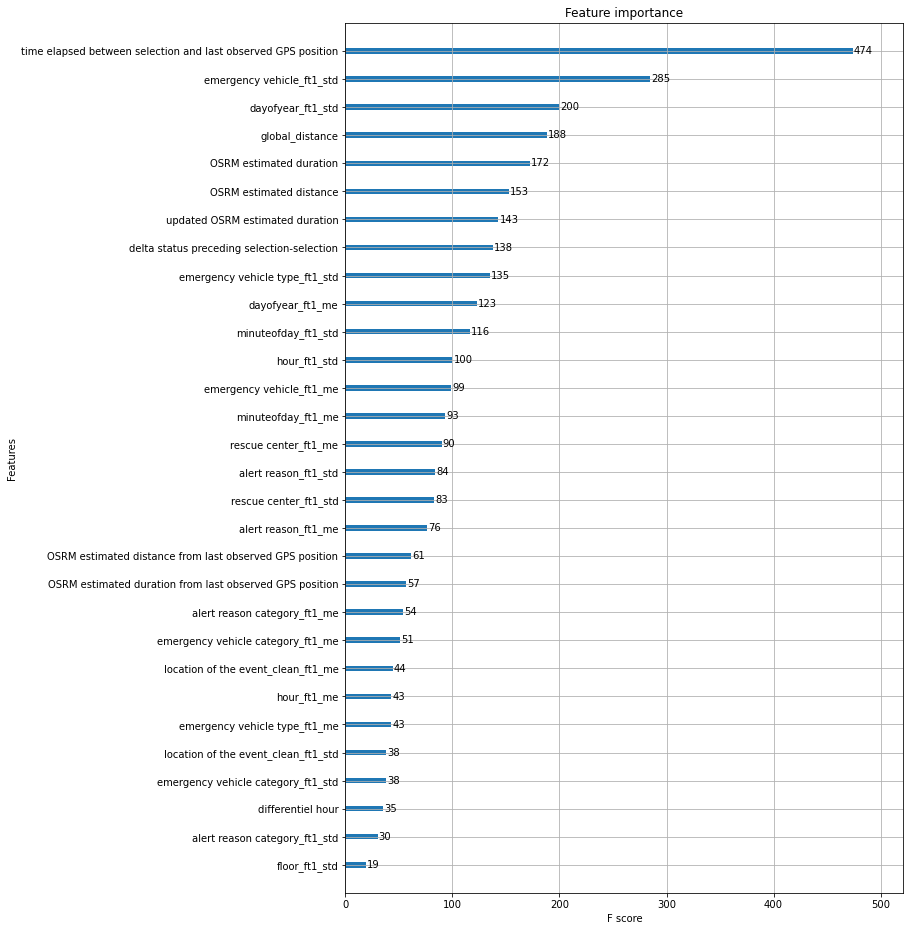

In [19]:
fig, ax = plt.subplots(figsize=(10, 16))
plot_importance(xgbs["delta departure-presentation"],
                max_num_features=30, ax=ax)  # top 10 most important features
plt.show()

In [20]:
df_scores = pd.DataFrame(scores)
df_scores['global_score'] = df_scores.mean(axis=1).round(3)
df_scores = df_scores.append(df_scores.mean().round(3), ignore_index=True)
df_scores.index = targets + ['mean over targets']
df_scores

,1-fold,2-fold,3-fold,4-fold,global_score
delta selection-departure,0.286,0.285,0.247,0.251,0.267
delta departure-presentation,0.394,0.359,0.327,0.449,0.382
delta selection-presentation,0.426,0.389,0.357,0.471,0.411
mean over targets,0.369,0.344,0.310,0.390,0.353


(0.0, 2000.0)

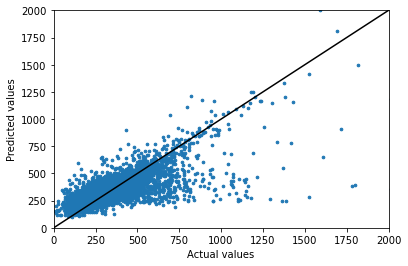

In [21]:
t_col = targets[1]

plt.scatter(y_vals[t_col][::10], y_pred[t_col][::10], s=7)

plt.plot(range(10000), 'black')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.xlim(0, 2000)
plt.ylim(0, 2000)

# Prediction

In [2]:
preds = list(y_pred_test.keys())
selection_cols = list(filter(lambda x: "delta selection-departure" in x, preds))
departure_cols = list(filter(lambda x: "delta departure-presentation" in x, preds))

In [ ]:
selection_values = np.array([y_pred_test[d] for d in selection_cols]).mean(axis=0)
departure_values = np.array([y_pred_test[d] for d in departure_cols]).mean(axis=0)
selection_presentation_values = selection_values + departure_values

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Data reading
x_train = pd.read_csv(BASE_PATH + 'x_train.csv', sep=',')
y_train = pd.read_csv(BASE_PATH + 'y_train.csv', sep=',')
x_test = pd.read_csv(BASE_PATH + 'x_test.csv', sep=',')
print('loaded')

x_train_transit = x_train[['OSRM estimated distance',
                           'intervention on public roads', 'floor']]
y_train_transit = y_train[['delta departure-presentation']]
x_test_transit = x_test[['OSRM estimated distance',
                         'intervention on public roads', 'floor']]

# Create a predictive model for the 'delta departure-presentation'
# based on 'OSRM estimated distance', 'intervention on public roads' and 'floor'
polynomial_features = PolynomialFeatures(degree=3)
x_train_transit_poly = polynomial_features.fit_transform(x_train_transit)
model = LinearRegression()
model.fit(x_train_transit_poly, y_train_transit)

# Prediction of the 'delta selection-presentation'
x_test_transit_poly = polynomial_features.fit_transform(x_test_transit)
y_selection_presentation_predicted = y_train['delta selection-departure'].median(
) + model.predict(x_test_transit_poly)

# Create a submission file
submission = pd.concat([pd.DataFrame(x_test[['emergency vehicle selection']].values),
                        pd.DataFrame(
                            np.full((len(x_test), 1), y_train['delta selection-departure'].median())),
                        pd.DataFrame(model.predict(x_test_transit_poly)),
                        pd.DataFrame(y_selection_presentation_predicted)],
                       axis=1)

submission.columns = list(y_train.columns.values)

submission.set_index('emergency vehicle selection', inplace=True)

In [ ]:
submission.head()

In [ ]:
submission[targets[0]] = selection_values
submission[targets[1]] = departure_values
submission[targets[2]] = selection_presentation_values

k = np.random.randint(0, 1_000)
submission.to_csv(f"predictions_{k}.csv")

In [ ]:
submission.head(5)

In [ ]:
print('–' * 30)
for t_col in targets:
    print(t_col, '\n')
    train_mean = y_train[t_col].mean()
    pred_mean = submission[t_col].mean()
    print(f'Train mean {train_mean:.3f}')
    print(f'Pred  mean {pred_mean:.3f}', '\n')
    assert np.isclose(train_mean, pred_mean, atol=2)

    train_std = y_train[t_col].std()
    pred_std = submission[t_col].std()
    print(f'Train std {train_std:.3f}')
    print(f'Pred  std {pred_std:.3f}',
          '\n––––––––––––––––––––––––––––\n')